<a href="https://colab.research.google.com/github/data-xen/data-xen.github.io/blob/main/train_kaggle__in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food41/food_test_c101_n1000_r64x64x3.h5
/kaggle/input/food41/food_c101_n10099_r32x32x3.h5
/kaggle/input/food41/food_c101_n1000_r384x384x3.h5
/kaggle/input/food41/food_test_c101_n1000_r128x128x3.h5
/kaggle/input/food41/food_test_c101_n1000_r32x32x3.h5
/kaggle/input/food41/food_test_c101_n1000_r32x32x1.h5
/kaggle/input/food41/food_test_c101_n1000_r128x128x1.h5
/kaggle/input/food41/food_c101_n10099_r64x64x1.h5
/kaggle/input/food41/food_c101_n10099_r64x64x3.h5
/kaggle/input/food41/food_test_c101_n1000_r64x64x1.h5
/kaggle/input/food41/food_c101_n10099_r32x32x1.h5
/kaggle/input/food41/meta/meta/test.txt
/kaggle/input/food41/meta/meta/train.json
/kaggle/input/food41/meta/meta/labels.txt
/kaggle/input/food41/meta/meta/test.json
/kaggle/input/food41/meta/meta/train.txt
/kaggle/input/food41/meta/meta/classes.txt
/kaggle/input/food41/images/macarons/2428554.jpg
/kaggle/input/food41/images/macarons/3842133.jpg
/kaggle/input/food41/images/macarons/1963752.jpg
/kaggle/input/food41/imag

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# --- 1. SETUP AND CONFIGURATION ---

# Define key parameters
IMG_SIZE = (224, 224) # Input image size for EfficientNetB0
BATCH_SIZE = 32      # Number of images to process at a time
EPOCHS = 10          # Number of times to go through the entire dataset

# Define the path to your data
# The Food-101 dataset has 'images' and 'meta' folders. We need the 'images'.
main_dir = '/kaggle/input/food41/images'

In [ ]:
# --- 2. DATA LOADING AND PREPROCESSING ---
# We will create training and validation datasets directly from the directories.
# Kaggle's Food-101 dataset doesn't have a predefined train/validation split,
# so we'll create one using a subset of the data.

print("Loading and preprocessing data...")

# Create the training dataset (80% of the data)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.2,   # Use 20% of the data for validation
    subset="training",
    seed=123,               # Seed for reproducibility
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Create the validation dataset (20% of the data)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names
class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} classes.")

Loading and preprocessing data...
Found 101000 files belonging to 101 classes.
Using 80800 files for training.


I0000 00:00:1757745005.811623      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757745005.812333      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
Found 101 classes.


In [ ]:
# --- 3. DATA AUGMENTATION ---
# Create a data augmentation layer to prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
# --- 4. BUILD THE MODEL WITH TRANSFER LEARNING ---

print("Building the model...")

# Load the EfficientNetB0 model, pre-trained on ImageNet
# include_top=False means we don't include the final classification layer
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,), # (224, 224, 3)
    include_top=False,
    weights='imagenet'
)

# Freeze the base model - we don't want to retrain the learned ImageNet features yet
base_model.trainable = False

# Create our own model on top of the base_model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)  # Apply augmentation first
x = base_model(x, training=False) # Set training=False for the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Pool the features
x = tf.keras.layers.Dropout(0.2)(x) # Add dropout for regularization
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x) # Final classification layer

model = tf.keras.Model(inputs, outputs)

Building the model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# We need to tell the model how to learn
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy", # Use this for integer labels
    metrics=["accuracy"]
)

# Print a summary of the model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# --- 6. TRAIN THE MODEL ---

print(f"Starting training for {EPOCHS} epochs...")

# Add a callback to stop training early if validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, # Stop after 3 epochs of no improvement
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Starting training for 10 epochs...
Epoch 1/10


E0000 00:00:1757745278.225594      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1757745280.789943     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 259s 95ms/step - accuracy: 0.3938 - loss: 2.6261 - val_accuracy: 0.6210 - val_loss: 1.4749
Epoch 2/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 218s 87ms/step - accuracy: 0.5670 - loss: 1.7013 - val_accuracy: 0.6424 - val_loss: 1.3813
Epoch 3/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 218s 86ms/step - accuracy: 0.5902 - loss: 1.5913 - val_accuracy: 0.6541 - val_loss: 1.3360
Epoch 4/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 218s 86ms/step - accuracy: 0.6013 - loss: 1.5418 - val_accuracy: 0.6595 - val_loss: 1.3108
Epoch 5/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 218s 86ms/step - accuracy: 0.6057 - loss: 1.5150 - val_accuracy: 0.6629 - val_loss: 1.2970
Epoch 6/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 218s 86ms/step - accuracy: 0.6117 - loss: 1.5003 - val_accuracy: 0.6645 - val_loss: 1.2905
Epoch 7/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 219s 87ms/step - accuracy: 0.6159 - loss: 1.4798 - val_accuracy: 0.6699 - val_loss: 1.2779
Epoch 8/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 219s 87ms/step - accuracy: 0.6142 - lo

Visualizing training history...


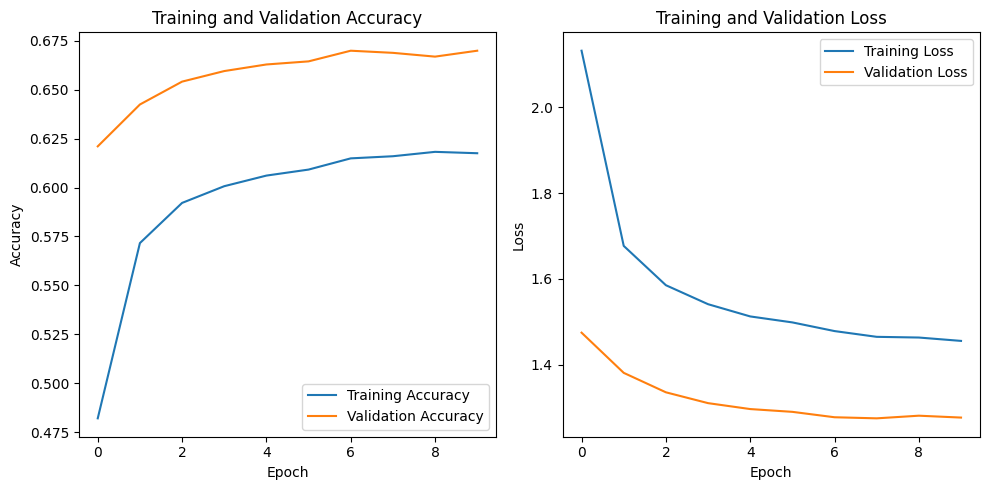

In [ ]:
# --- 7. VISUALIZE TRAINING RESULTS ---

print("Visualizing training history...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [ ]:
# --- 8. EVALUATE THE MODEL ---

print("Evaluating the final model on the validation set...")
final_loss, final_accuracy = model.evaluate(validation_dataset)
print(f"Final Validation Loss: {final_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

Evaluating the final model on the validation set...
632/632 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.6705 - loss: 1.2694
Final Validation Loss: 1.2754
Final Validation Accuracy: 0.6688


In [ ]:
# --- FINE-TUNING STAGE ---

# Unfreeze the base model
base_model.trainable = True

# Let's see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards. Let's unfreeze the top 20 layers.
fine_tune_at = len(base_model.layers) - 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a very low learning rate
# This is crucial to prevent destroying the pre-trained weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Much lower learning rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Starting fine-tuning...")

# Continue training the model (fine-tuning)
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where the last training finished
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Number of layers in the base model:  238
Starting fine-tuning...
Epoch 10/20


E0000 00:00:1757747737.106597      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 266s 98ms/step - accuracy: 0.4554 - loss: 2.2292 - val_accuracy: 0.6439 - val_loss: 1.3935
Epoch 11/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 244s 96ms/step - accuracy: 0.5761 - loss: 1.6415 - val_accuracy: 0.6655 - val_loss: 1.3101
Epoch 12/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 247s 98ms/step - accuracy: 0.6073 - loss: 1.5177 - val_accuracy: 0.6770 - val_loss: 1.2650
Epoch 13/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.6231 - loss: 1.4402 - val_accuracy: 0.6843 - val_loss: 1.2319
Epoch 14/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.6354 - loss: 1.3946 - val_accuracy: 0.6901 - val_loss: 1.2084
Epoch 15/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 247s 98ms/step - accuracy: 0.6433 - loss: 1.3473 - val_accuracy: 0.6944 - val_loss: 1.1886
Epoch 16/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 244s 97ms/step - accuracy: 0.6501 - loss: 1.3184 - val_accuracy: 0.6992 - val_loss: 1.1703
Epoch 17/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 247s 98ms/step - accuracy: 0.65

In [ ]:
# --- Experiment 1: Feature Extraction ---
# Re-build your initial model (or use the one from before if it's still in memory)
# (Ensure the base_model is frozen: base_model.trainable = False)

# ... [Your code for building the initial model] ...
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("--- Running Experiment 1: Feature Extraction ---")
# Use a new variable name to store this history
history_initial = model.fit(
    train_dataset,
    epochs=10, # Can be fewer epochs as it converges fast
    validation_data=validation_dataset,
    callbacks=[early_stopping] # Use your early stopping callback
)

print("--- Finished Experiment 1 ---")

--- Running Experiment 1: Feature Extraction ---
Epoch 1/10


E0000 00:00:1757751552.812591      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 265s 97ms/step - accuracy: 0.6066 - loss: 1.5051 - val_accuracy: 0.7136 - val_loss: 1.1147
Epoch 2/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.6745 - loss: 1.2213 - val_accuracy: 0.7345 - val_loss: 1.0238
Epoch 3/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.7045 - loss: 1.0955 - val_accuracy: 0.7402 - val_loss: 1.0101
Epoch 4/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 242s 96ms/step - accuracy: 0.7258 - loss: 0.9961 - val_accuracy: 0.7438 - val_loss: 0.9882
Epoch 5/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 242s 96ms/step - accuracy: 0.7449 - loss: 0.9183 - val_accuracy: 0.7528 - val_loss: 0.9773
Epoch 6/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 242s 96ms/step - accuracy: 0.7596 - loss: 0.8550 - val_accuracy: 0.7477 - val_loss: 1.0008
Epoch 7/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 242s 96ms/step - accuracy: 0.7747 - loss: 0.8030 - val_accuracy: 0.7538 - val_loss: 0.9945
Epoch 8/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 242s 96ms/step - accuracy: 0.7816 - lo

In [ ]:
# --- Experiment 2: Training from Scratch ---

print("--- Building Experiment 2 Model: From Scratch ---")

# 1. Load the EfficientNetB0 ARCHITECTURE WITHOUT pre-trained weights
base_model_scratch = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights=None  # This is the key part for a "from-scratch" model
)

# 2. Set the entire base model to be trainable
base_model_scratch.trainable = True

# 3. Add your classification head on top
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model_scratch(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

# 4. Create the final model - THIS DEFINES 'model_scratch'
model_scratch = tf.keras.Model(inputs, outputs)


# 5. NOW you can compile it
print("Compiling the from-scratch model...")
model_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# (Optional) Print summary to confirm it's built correctly
model_scratch.summary()


# 6. Train the model
print("--- Running Experiment 2: From Scratch ---")
history_scratch = model_scratch.fit(
    train_dataset,
    epochs=20, # This model may need more epochs to learn
    validation_data=validation_dataset,
    callbacks=[early_stopping] # Your early stopping callback
)

print("--- Finished Experiment 2 ---")

--- Building Experiment 2 Model: From Scratch ---
Compiling the from-scratch model...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 4,136,929 (15.78 MB)

 Non-trainable params: 42,023 (164.16 KB)

--- Running Experiment 2: From Scratch ---
Epoch 1/20


E0000 00:00:1757758358.133363      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 925s 344ms/step - accuracy: 0.0215 - loss: 4.5769 - val_accuracy: 0.0588 - val_loss: 4.3276
Epoch 2/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 862s 342ms/step - accuracy: 0.0746 - loss: 4.1168 - val_accuracy: 0.1054 - val_loss: 3.9269
Epoch 3/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 863s 342ms/step - accuracy: 0.1203 - loss: 3.8212 - val_accuracy: 0.1567 - val_loss: 3.6076
Epoch 4/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 863s 342ms/step - accuracy: 0.1609 - loss: 3.5887 - val_accuracy: 0.1991 - val_loss: 3.3723
Epoch 5/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 863s 342ms/step - accuracy: 0.1933 - loss: 3.3898 - val_accuracy: 0.2318 - val_loss: 3.2226
Epoch 6/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 865s 342ms/step - accuracy: 0.2281 - loss: 3.2139 - val_accuracy: 0.2736 - val_loss: 2.9913
Epoch 7/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 865s 343ms/step - accuracy: 0.2589 - loss: 3.0559 - val_accuracy: 0.2990 - val_loss: 2.8822
Epoch 8/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 863s 342ms/step - accuracy: 0.2

In [ ]:
# --- Experiment 3: Fine-Tuning ---
# Note: For a proper experiment, you would typically use the model
# that has finished the feature extraction training from Experiment 1.

# Unfreeze the layers for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile with a low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("--- Running Experiment 3: Fine-Tuning ---")
# Use a new variable for this history
history_fine_tune = model.fit(
    train_dataset,
    epochs=20, # Or your desired number of fine-tuning epochs
    initial_epoch=history_initial.epoch[-1], # Optional: start where the last one left off
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

print("--- Finished Experiment 3 ---")

--- Running Experiment 3: Fine-Tuning ---
Epoch 8/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 267s 97ms/step - accuracy: 0.7673 - loss: 0.8281 - val_accuracy: 0.7655 - val_loss: 0.9201
Epoch 9/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.7780 - loss: 0.7879 - val_accuracy: 0.7697 - val_loss: 0.9072
Epoch 10/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 244s 96ms/step - accuracy: 0.7831 - loss: 0.7657 - val_accuracy: 0.7728 - val_loss: 0.9001
Epoch 11/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.7891 - loss: 0.7470 - val_accuracy: 0.7743 - val_loss: 0.8938
Epoch 12/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 244s 96ms/step - accuracy: 0.7949 - loss: 0.7324 - val_accuracy: 0.7761 - val_loss: 0.8897
Epoch 13/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 244s 96ms/step - accuracy: 0.7968 - loss: 0.7224 - val_accuracy: 0.7768 - val_loss: 0.8865
Epoch 14/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.7986 - loss: 0.7144 - val_accuracy: 0.7776 - val_loss: 0.8844
Epoch 15/20
2525/2525 

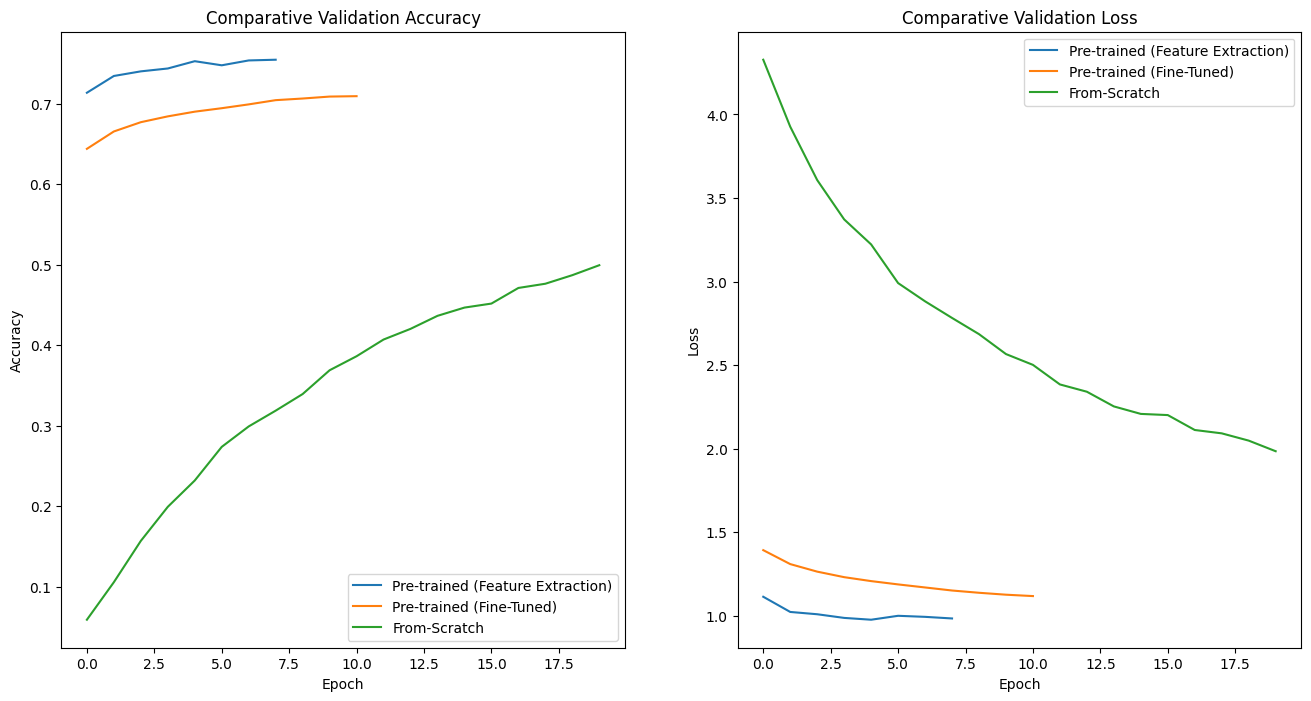

In [ ]:
# --- 1. COMPARATIVE VISUALIZATION OF TRAINING HISTORY ---

# You should have three 'history' objects: history_initial, history_fine_tune, history_scratch

plt.figure(figsize=(16, 8))

# Plot Comparative Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['val_accuracy'], label='Pre-trained (Feature Extraction)')
plt.plot(history_fine_tune.history['val_accuracy'], label='Pre-trained (Fine-Tuned)')
plt.plot(history_scratch.history['val_accuracy'], label='From-Scratch')
plt.title('Comparative Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Comparative Loss
plt.subplot(1, 2, 2)
plt.plot(history_initial.history['val_loss'], label='Pre-trained (Feature Extraction)')
plt.plot(history_fine_tune.history['val_loss'], label='Pre-trained (Fine-Tuned)')
plt.plot(history_scratch.history['val_loss'], label='From-Scratch')
plt.title('Comparative Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# --- 2. VISUALIZE MODEL ARCHITECTURE ---

# This will save a diagram of your model architecture to a file
tf.keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True
)
print("Model architecture saved to model_architecture.png")

Model architecture saved to model_architecture.png


Generating predictions for confusion matrix...


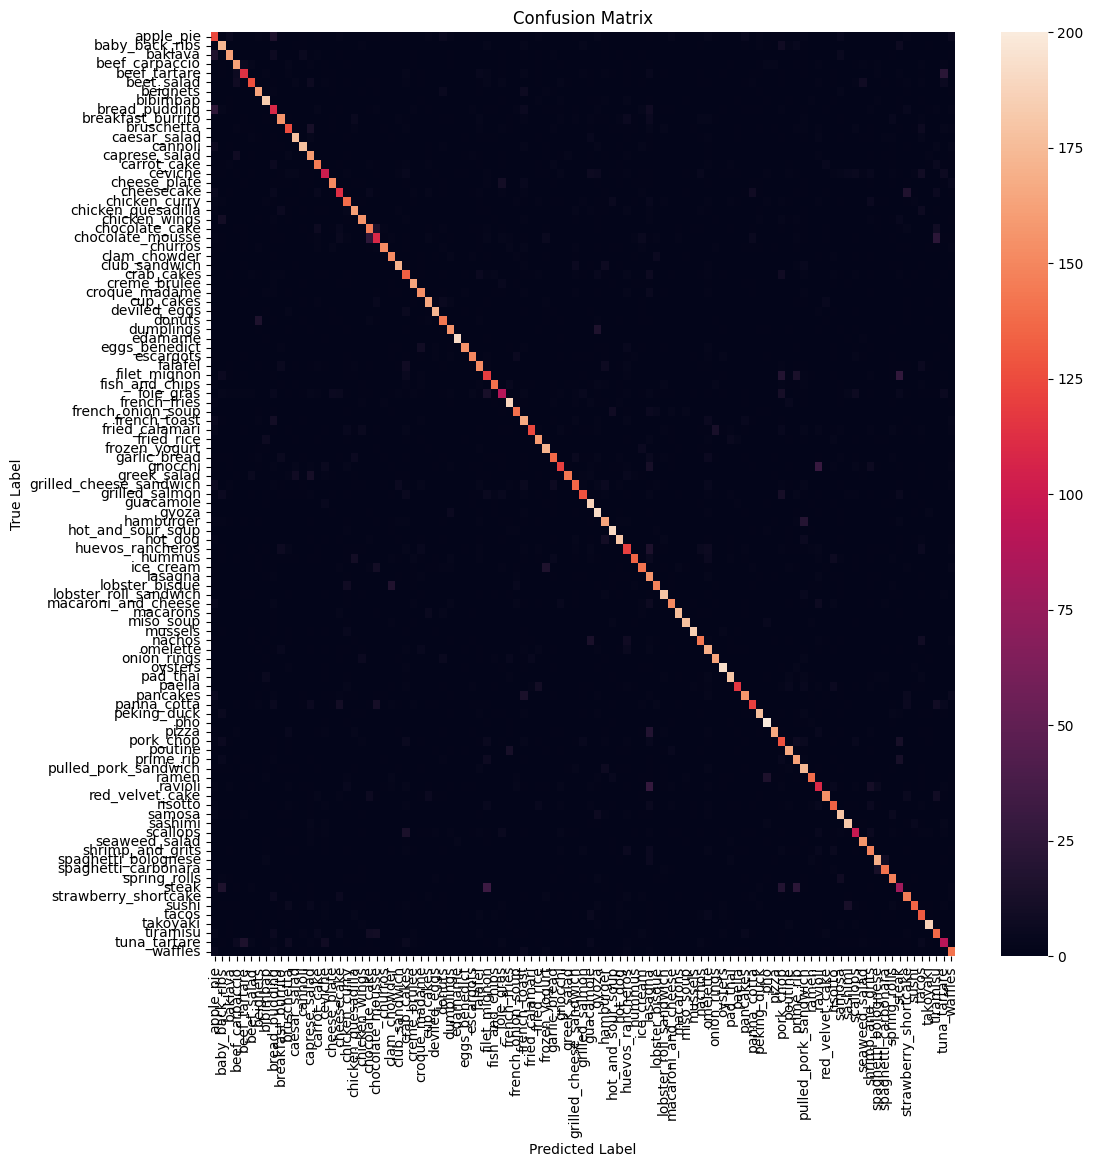

In [ ]:
# You might need to run: !pip install scikit-learn seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns

# --- 3. CONFUSION MATRIX ---

# Make predictions on the entire validation dataset
print("Generating predictions for confusion matrix...")
y_pred = []
y_true = []
for images, labels in validation_dataset:
    y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=1))
    y_true.extend(labels.numpy())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# --- 4. CLASSIFICATION REPORT ---

print(classification_report(y_true, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.48      0.60      0.53       205
         baby_back_ribs       0.68      0.80      0.74       215
                baklava       0.83      0.76      0.79       213
         beef_carpaccio       0.79      0.78      0.79       207
           beef_tartare       0.74      0.60      0.66       190
             beet_salad       0.79      0.63      0.70       203
               beignets       0.80      0.86      0.83       191
               bibimbap       0.82      0.88      0.85       209
          bread_pudding       0.49      0.55      0.52       198
      breakfast_burrito       0.77      0.72      0.75       216
             bruschetta       0.66      0.65      0.65       193
           caesar_salad       0.86      0.82      0.84       216
                cannoli       0.87      0.84      0.85       212
          caprese_salad       0.67      0.81      0.73       196
            carrot_cake 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


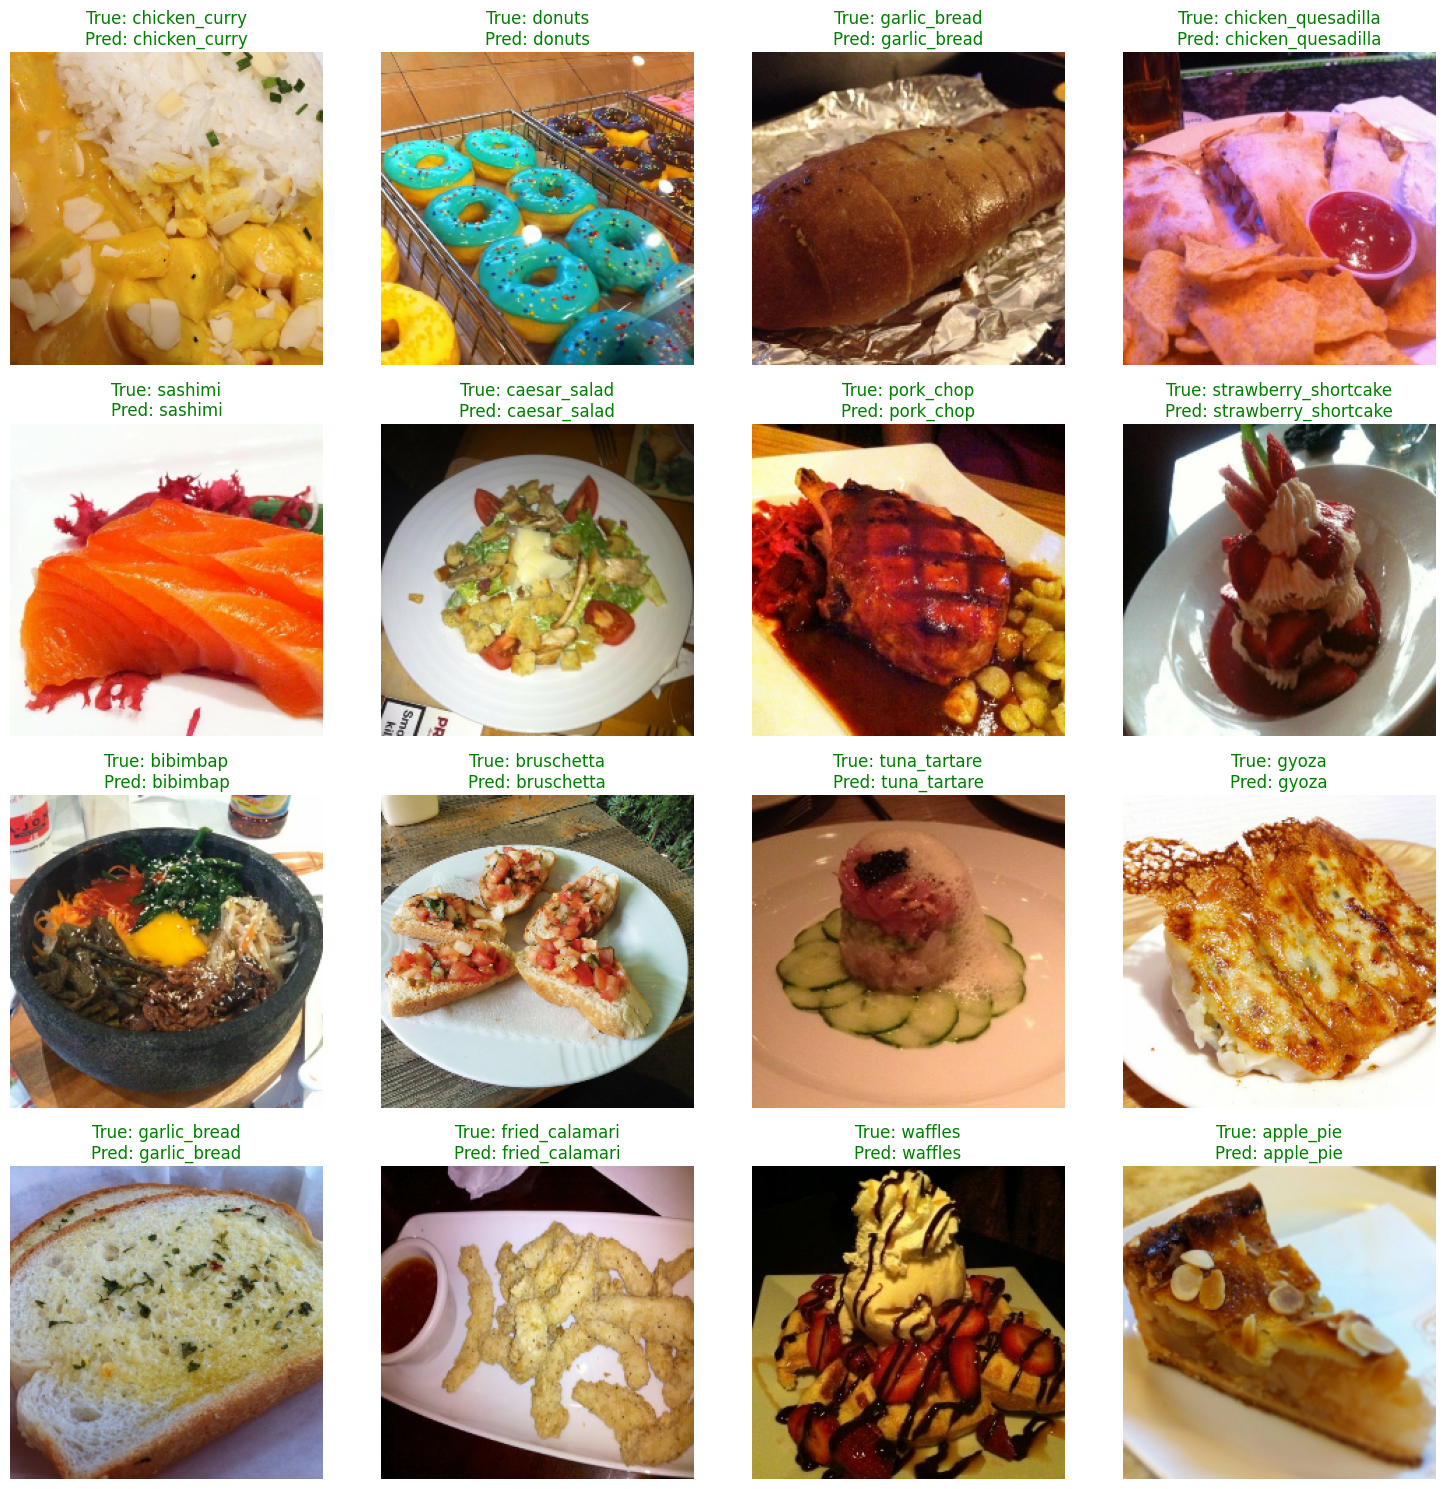

In [ ]:
# --- 5. VISUALIZE EXAMPLE PREDICTIONS ---

plt.figure(figsize=(15, 15))
# Take one batch from the validation dataset
for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)

    for i in range(16): # Show the first 16 images in the batch
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = class_names[labels[i]]
        pred_label = class_names[pred_labels[i]]

        # Color the title green for correct, red for incorrect
        title_color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis("off")
plt.tight_layout()
plt.show()

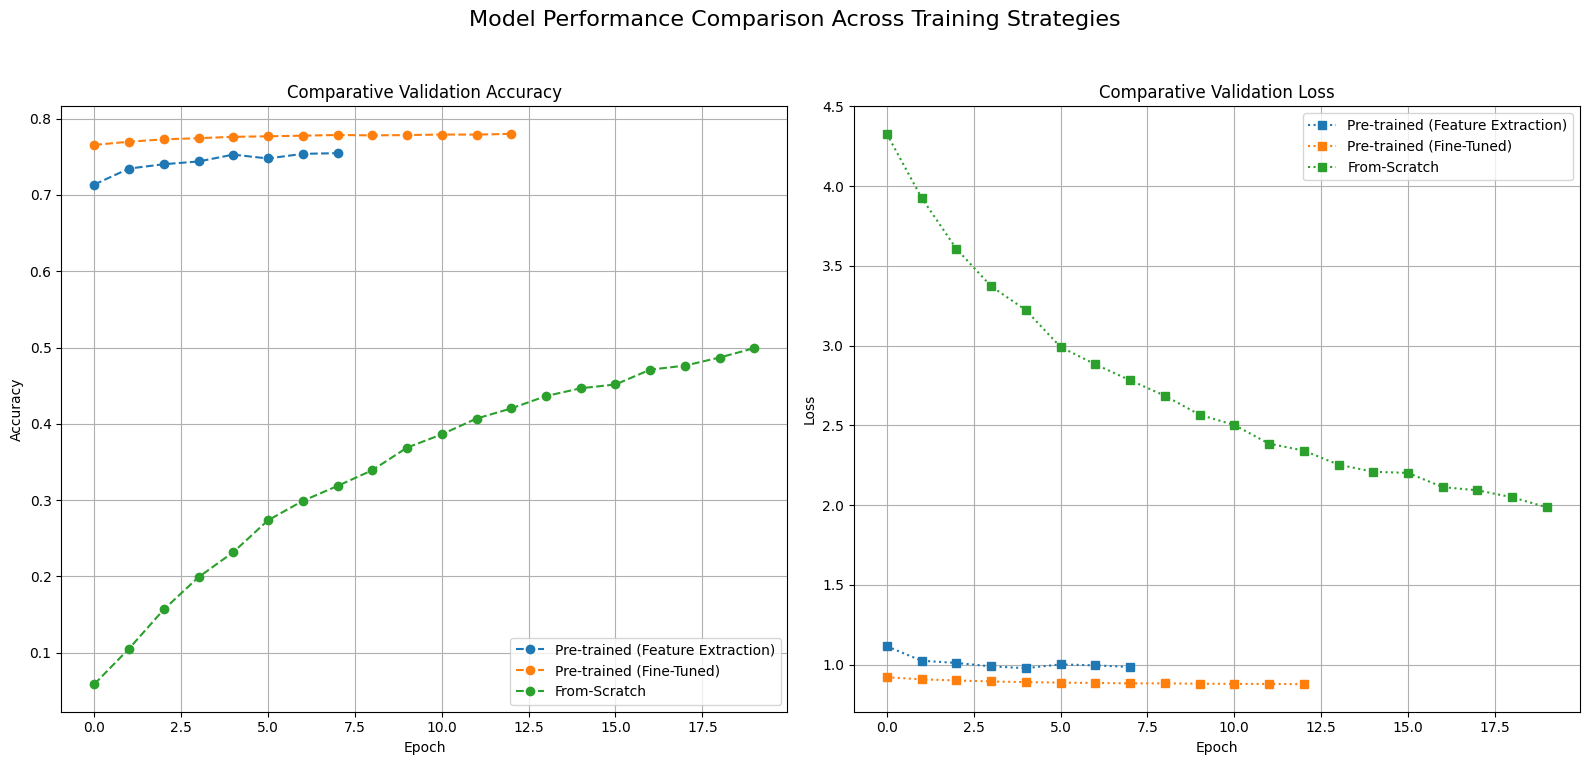

In [1]:
import matplotlib.pyplot as plt

# --- Data Reconstruction from Logs ---
# The following data is manually transcribed from the training output logs you provided.

# Experiment 1: Feature Extraction (Pre-trained, frozen base)
# Ran for 8 epochs.
history_initial = {
    'val_accuracy': [0.7136, 0.7345, 0.7402, 0.7438, 0.7528, 0.7477, 0.7538, 0.7547],
    'val_loss': [1.1147, 1.0238, 1.0101, 0.9882, 0.9773, 1.0008, 0.9945, 0.9849]
}

# Experiment 2: Training from Scratch (Randomly initialized weights)
# Ran for 20 epochs.
history_scratch = {
    'val_accuracy': [
        0.0588, 0.1054, 0.1567, 0.1991, 0.2318, 0.2736, 0.2990, 0.3186, 0.3392, 0.3688,
        0.3862, 0.4069, 0.4202, 0.4364, 0.4466, 0.4516, 0.4710, 0.4763, 0.4869, 0.4993
    ],
    'val_loss': [
        4.3276, 3.9269, 3.6076, 3.3723, 3.2226, 2.9913, 2.8822, 2.7827, 2.6858, 2.5666,
        2.5020, 2.3849, 2.3413, 2.2535, 2.2086, 2.2016, 2.1124, 2.0923, 2.0488, 1.9854
    ]
}

# Experiment 3: Fine-Tuning (Pre-trained, top layers unfrozen)
# Ran for 13 epochs (from epoch 8 to 20 in the log).
history_fine_tune = {
    'val_accuracy': [
        0.7655, 0.7697, 0.7728, 0.7743, 0.7761, 0.7768, 0.7776, 0.7785, 0.7780, 0.7784,
        0.7791, 0.7790, 0.7800
    ],
    'val_loss': [
        0.9201, 0.9072, 0.9001, 0.8938, 0.8897, 0.8865, 0.8844, 0.8820, 0.8819, 0.8797,
        0.8786, 0.8784, 0.8766
    ]
}


# --- Comparative Visualization of Training History ---
# This plotting code is adapted from your original script [cite: 2]
# to visualize the manually entered data.

plt.figure(figsize=(16, 8))

# Plot Comparative Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_initial['val_accuracy'], label='Pre-trained (Feature Extraction)', marker='o', linestyle='--')
plt.plot(history_fine_tune['val_accuracy'], label='Pre-trained (Fine-Tuned)', marker='o', linestyle='--')
plt.plot(history_scratch['val_accuracy'], label='From-Scratch', marker='o', linestyle='--')
plt.title('Comparative Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Comparative Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_initial['val_loss'], label='Pre-trained (Feature Extraction)', marker='s', linestyle=':')
plt.plot(history_fine_tune['val_loss'], label='Pre-trained (Fine-Tuned)', marker='s', linestyle=':')
plt.plot(history_scratch['val_loss'], label='From-Scratch', marker='s', linestyle=':')
plt.title('Comparative Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Model Performance Comparison Across Training Strategies', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()